<a href="https://colab.research.google.com/github/Chutannn/D121231006-MOBILE2025-W1/blob/main/Session_20_Batch_Runner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')


try:
  import mesa
except:
  !pip install mesa==1.1.0
import mesa
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.9 MB/s eta 0:00:00


# Helper Functions

In [2]:
def get_distance(pos_1, pos_2):
  '''
  Calculate the Euclidean distance between two positions

  used in trade.move()
  '''

  x1, y1 = pos_1
  x2, y2 = pos_2
  dx = x1 - x2
  dy = y1 - y2
  return math.sqrt(dx**2 + dy**2)

def flatten(list_of_lists):
  '''
  helper function for model datacollector for trade price
  collapses agent price list into one list
  '''
  return [item for sublist in list_of_lists for item in sublist]

def geometric_mean(list_of_prices):
  '''
  find the geometric mean of a list of prices
  '''
  return np.exp(np.log(list_of_prices).mean())

def get_trade(agent):
  '''
  For agent reportes in data collector

  return list of trade partners and None for other agents
  '''
  if type(agent) == Trader:
    return agent.trade_partners
  else: return None

# Resource Classes

In [3]:
class Sugar(mesa.Agent):
  """
  Sugar:
  - contains an amount of sugar
  - grows 1 amount of sugar at each turn
  """

  def __init__(self, unique_id, model, pos, max_sugar):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_sugar
    self.max_sugar = max_sugar


  def step(self):
    '''
    Sugar growth function, adds one unit of sugar each step until
    max amount
    '''
    self.amount = min([self.max_sugar, self.amount+1])

In [4]:
class Spice(mesa.Agent):
  """
  Spice:
  - contains an amount of spice
  - grows 1 amount of spice at each turn
  """

  def __init__(self, unique_id, model, pos, max_spice):
    super().__init__(unique_id, model)
    self.pos = pos
    self.amount = max_spice
    self.max_spice = max_spice

  def step(self):
    '''
    Spice growth function, adds one unit of spice each step until
    max amout
    '''
    self.amount = min([self.max_spice, self.amount+1])

# Trader Agent

In [5]:
class Trader(mesa.Agent):
  """
  Trader:
  - has a metabolism of sugar and spice
  - harvest and trade sugar and spice to survive
  """


  def __init__(self, unique_id, model, pos, moore=False, sugar=0,
               spice=0, metabolism_sugar=0, metabolism_spice=0,
               vision=0):
    super().__init__(unique_id, model)
    self.pos = pos
    self.moore = moore
    self.sugar = sugar
    self.spice = spice
    self.metabolism_sugar = metabolism_sugar
    self.metabolism_spice = metabolism_spice
    self.vision = vision
    self.prices = []
    self.trade_partners = []


  def get_sugar(self, pos):
    '''
    used in self.get_sugar_amount()
    '''

    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if type(agent) is Sugar:
        return agent
    return None


  def get_sugar_amount(self,pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''

    sugar_patch = self.get_sugar(pos)
    if sugar_patch:
      return sugar_patch.amount
    return 0

  def get_spice(self, pos):
    '''
    used in self.get_spice_amount()
    '''

    this_cell = self.model.grid.get_cell_list_contents(pos)
    for agent in this_cell:
      if type(agent) is Spice:
        return agent
    return None

  def get_spice_amount(self, pos):
    '''
    used in self.move() as part of self.calculate_welfare()
    '''

    spice_patch = self.get_spice(pos)
    if spice_patch:
      return spice_patch.amount
    return 0

  def get_trader(self, pos):
      '''
      helper function used in self.trade_with_neighbors()
      '''

      this_cell = self.model.grid.get_cell_list_contents(pos)

      for agent in this_cell:
        if isinstance(agent, Trader):
          return agent


  def is_occupied_by_other(self,pos):
    '''
    helper function part 1 of self.move()
    '''

    if pos == self.pos:
      # agent's position is considered unoccupied as agent can stay there
      return False
    # get contents of each cell in neighborhood
    this_cell = self.model.grid.get_cell_list_contents(pos)
    for a in this_cell:
      # see if occupied by another agent
      if isinstance(a, Trader):
        return True
    return False

  def calculate_welfare(self, sugar, spice):
    '''
    helper function

    part 2 self.move()
    self.trade()
    '''

    # calculate total resources
    m_total = self.metabolism_sugar + self.metabolism_spice
    # Cobb-Douglas functional form; starting on p. 97 on Growing Artificial Societies
    return sugar**(self.metabolism_sugar/m_total) * spice**(
        self.metabolism_spice/m_total)


  def is_starved(self):
    '''
    Helper function for self.maybe_die()
    '''

    return (self.sugar <= 0) or (self.spice <= 0)

  def calculate_MRS(self, sugar, spice):
    '''
    Helper function for
    - self.trade()
    - self.maybe_sell_spice()

    Determines what trader agent is needs and can give up
    '''

    return (spice/self.metabolism_spice) / (sugar/self.metabolism_sugar)

  def calculate_sell_spice_amount(self, price):
    '''
    helper function for self.maybe_sell_spice() which is called from
    self.trade()
    '''

    if price >= 1:
      sugar = 1
      spice = int(price)
    else:
      sugar = int(1/price)
      spice = 1
    return sugar, spice

  def sell_spice(self, other, sugar, spice):
    '''
    used in self.maybe_sell_spice()

    exchanges sugar and spice between traders
    '''

    self.sugar += sugar
    other.sugar -= sugar
    self.spice -= spice
    other.spice += spice


  def maybe_sell_spice(self, other, price, welfare_self, welfare_other):
    '''
    helper function for self.trade()
    '''

    sugar_exchanged, spice_exchanged = self.calculate_sell_spice_amount(price)

    # Assess new sugar and spice amount - what if change did occur
    self_sugar = self.sugar + sugar_exchanged
    other_sugar = other.sugar - sugar_exchanged
    self_spice = self.spice - spice_exchanged
    other_spice = other.spice + spice_exchanged

    # double check to ensure agents have resources

    if ((self_sugar <= 0) or
        (other_sugar <=0) or
        (self_spice <= 0) or
        (other_spice <= 0)):
      return False

    # trade criteria #1 - are both agents better off?
    both_agents_better_off = (
        (welfare_self < self.calculate_welfare(self_sugar, self_spice)) and
        (welfare_other < other.calculate_welfare(other_sugar, other_spice)))

    # trade criteria #2 is their mrs crossing
    mrs_not_crossing = self.calculate_MRS(
        self_sugar, self_spice
    ) > other.calculate_MRS(other_sugar, other_spice)

    if not (both_agents_better_off and mrs_not_crossing):
      return False

    # criteria met, execute trade
    self.sell_spice(other, sugar_exchanged, spice_exchanged)

    return True


  def trade(self, other):
    '''
    helper function used in trade_with_neighbors()

    other is a trader agent object
    '''

    # sanity check to verify code is working as expected
    assert self.sugar > 0
    assert self.spice > 0
    assert other.sugar > 0
    assert other.spice > 0

    # calculate marginal rate of subsitution in Growing Artificial Socieites p. 101
    mrs_self = self.calculate_MRS(self.sugar, self.spice)
    mrs_other = other.calculate_MRS(other.sugar, other.spice)

    #calculate each agents welfare
    welfare_self = self.calculate_welfare(self.sugar, self.spice)
    welfare_other = other.calculate_welfare(other.sugar, other.spice)

    if math.isclose(mrs_self, mrs_other):
      return

    # calcualte price
    price = math.sqrt(mrs_self*mrs_other)

    if mrs_self > mrs_other:
      # self is a sugar buyer, spice seller
      sold = self.maybe_sell_spice(other, price, welfare_self, welfare_other)
      # no trade - criteria not met
      if not sold:
        return
    else:
      # self is a spice buyer, sugar seller
      sold = other.maybe_sell_spice(self, price, welfare_other, welfare_self)
      # no trade - criteria not met
      if not sold:
        return

    # Capture data
    self.prices.append(price)
    self.trade_partners.append(other.unique_id)

    # continue trading
    self.trade(other)

  ######################################################################
  #                                                                    #
  #                      MAIN TRADE FUNCTIONS                          #
  #                                                                    #
  ######################################################################


  def move(self):
    '''
    Function for trader agent to identify optimal move for each step in 4 parts
    1 - identify all possible moves
    2 - determine which move maximizes welfare
    3 - find closest best option
    4 - move
    '''

    # 1. identify all possible moves

    neighbors = [i
                 for i in self.model.grid.get_neighborhood(
                   self.pos, self.moore, True, self.vision
                 ) if not self.is_occupied_by_other(i)]

    # 2. determine which move maximizes welfare

    welfares = [
        self.calculate_welfare(
            self.sugar + self.get_sugar_amount(pos),
            self.spice + self.get_spice_amount(pos))
        for pos in neighbors
    ]

    # 3. Find closest best option

    # find the highest welfare in welfares
    max_welfare = max(welfares)
    # get the index of max welfare cells
    candidate_indices = [i for i in range(len(welfares))
                        if math.isclose(welfares[i], max_welfare)]

    # convert index to positions of those cells
    candidates = [neighbors[i] for i in candidate_indices]

    min_dist = min(get_distance(self.pos, pos) for pos in candidates)

    final_candidates = [ pos for pos in candidates
                       if math.isclose(get_distance(self.pos, pos), min_dist, rel_tol=1e-02
                                       )]
    self.random.shuffle(final_candidates)

    # 4. Move Agent
    self.model.grid.move_agent(self, final_candidates[0])

  def eat(self):
    # get sugar
    sugar_patch = self.get_sugar(self.pos)

    if sugar_patch:
        self.sugar += sugar_patch.amount
        sugar_patch.amount = 0
    self.sugar -= self.metabolism_sugar

    # get_spice
    spice_patch = self.get_spice(self.pos)

    if spice_patch:
        self.spice += spice_patch.amount
        spice_patch.amount = 0
    self.spice -= self.metabolism_spice

  def maybe_die(self):
    '''
    Function to remove Traders who have consumed all their sugar or spice
    '''

    if self.is_starved():
      self.model.grid.remove_agent(self)
      self.model.schedule.remove(self)

  def trade_with_neighbors(self):
    '''
    Function for trader agents to decide who to trade with in three parts

    1- identify neighbors who can trade
    2- trade (2 sessions)
    3- collect data
    '''

    neighbor_agents = [self.get_trader(pos) for pos in self.model.grid.get_neighborhood(
        self.pos, self.moore, False, self.vision) if self.is_occupied_by_other(pos)
    ]

    if len(neighbor_agents) == 0:
      return


    # iterate through traders in neighboring cells and trade
    for a in neighbor_agents:
      if a:
        self.trade(a)

    return

# Model Class

In [8]:
class SugarscapeG1mt(mesa.Model):
  """
  Manager class to run Sugarscape with Traders
  """


  def __init__(self, width=50,height=50, initial_population=200,
               endowment_min=25, endowment_max=50, metabolism_min=1,
               metabolism_max=5, vision_min=1, vision_max=5):

    #Initiate width and heigh of sugarscape
    self.width = width
    self.height = height
    #Initiate population attributes
    self.initial_population = initial_population
    self.endowment_min = endowment_min
    self.endowment_max = endowment_max
    self.metabolism_min = metabolism_min
    self.metabolism_max = metabolism_max
    self.vision_min = vision_min
    self.vision_max = vision_max
    self.running = True

    # initiate activation schedule
    self.schedule = mesa.time.RandomActivationByType(self)
    # initiate mesa grid class
    self.grid = mesa.space.MultiGrid(self.width, self.height, torus=False)
    # initiate datacollector
    self.datacollector = mesa.DataCollector(
        model_reporters = {"Trader": lambda m: m.schedule.get_type_count(Trader),
         "Trade Volume": lambda m: sum(len(a.trade_partners)
         for a in m.schedule.agents_by_type[Trader].values()),
         "Price": lambda m: geometric_mean(flatten([a.prices for a in m.schedule.agents_by_type[Trader].values()]))},
       agent_reporters = {"Trade Network": lambda a: get_trade(a)}
    )


    #read in landscape file from supplmentary material
    sugar_distribution =np.genfromtxt("/content/drive/MyDrive/sugar-map.txt")
    spice_distribution = np.flip(sugar_distribution, 1)

    agent_id = 0
    for _,x,y in self.grid.coord_iter():
      max_sugar = sugar_distribution[x,y]
      if max_sugar > 0:
        sugar = Sugar(agent_id, self, (x,y), max_sugar)
        self.schedule.add(sugar)
        self.grid.place_agent(sugar, (x,y))
        agent_id += 1

      max_spice = spice_distribution[x,y]
      if max_spice > 0:
        spice = Spice(agent_id, self, (x,y), max_spice)
        self.schedule.add(spice)
        self.grid.place_agent(spice, (x,y))
        agent_id += 1

    for i in range(self.initial_population):
      #get agent position
      x = self.random.randrange(self.width)
      y = self.random.randrange(self.height)
      #see Growing Artificial Societies p. 108 for initialization
      #give agents initial endowment
      sugar = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      spice = int(self.random.uniform(self.endowment_min, self.endowment_max+1))
      #give agents initial metabolism
      metabolism_sugar = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      metabolism_spice = int(self.random.uniform(self.metabolism_min, self.metabolism_max+1))
      #give agents vision
      vision = int(self.random.uniform(self.vision_min, self.vision_max+1))
      #create Trader object
      trader = Trader(agent_id,
                      self,
                      (x,y),
                      moore = False,
                      sugar = sugar,
                      spice = spice,
                      metabolism_sugar = metabolism_sugar,
                      metabolism_spice = metabolism_spice,
                      vision = vision)
      #place agent
      self.grid.place_agent(trader, (x,y))
      self.schedule.add(trader)
      agent_id += 1

  def randomize_traders(self):
    '''
    helper function for self.step()

    puts traders in randomized list for step function
    '''

    trader_shuffle = list(self.schedule.agents_by_type[Trader].values())
    self.random.shuffle(trader_shuffle)

    return trader_shuffle


  def step(self):
    '''
    Unique step function that does staged activation of sugar and spice
    and then randomly activates traders
    '''
    # step Sugar agents
    for sugar in self.schedule.agents_by_type[Sugar].values():
      sugar.step()

    # step Spice agents
    for spice in self.schedule.agents_by_type[Spice].values():
      spice.step()

    # step trader agents
    # to account for agent death and removal we need a seperate data strcuture to
    # iterate
    trader_shuffle = self.randomize_traders()

    for agent in trader_shuffle:
      agent.prices = []
      agent.trade_partners = []
      agent.move()
      agent.eat()
      agent.maybe_die()

    trader_shuffle = self.randomize_traders()

    for agent in trader_shuffle:
      agent.trade_with_neighbors()

    self.schedule.steps += 1 #important for data collector to track number of steps

    # collect model level data
    self.datacollector.collect(self)

    #Need to remove excess data, as Mesa does not yet have a datacollection
    #by agent type feature we will for into datacollector to update its data
    #structures
    agent_trades = self.datacollector._agent_records[self.schedule.steps]
    #leverage None aspect of no data in data collector
    agent_trades = [agent for agent in agent_trades if agent[2] is not None]
    #reassign that step in the dictionary with lean trade data
    self.datacollector._agent_records[self.schedule.steps] = agent_trades

  def run_model(self, step_count=1000):

    for i in range(step_count):
      self.step()

# Run Sugarscape

In [9]:
model = SugarscapeG1mt()
model.run_model()


/tmp/ipython-input-1755629435.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Analyze Data

In [10]:
results = model.datacollector.get_model_vars_dataframe()

results

,Trader,Trade Volume,Price
0,200,812,0.958866
1,200,119,1.027759
2,200,135,1.053104
3,200,163,0.953054
4,200,112,0.866577
...,...,...,...
995,69,12,0.906484
996,69,30,0.626467
997,69,51,0.494479
998,69,9,0.762096


In [11]:
# retrieve agent level results
agent_results = model.datacollector.get_agent_vars_dataframe()
# filter out Nones from non-trader agents
agent_results

Trade Network
Step AgentID                                                   
1    4138                                    [4259, 4259, 4259]
     4139     [4210, 4210, 4210, 4210, 4210, 4210, 4210, 421...
     4140                                                    []
     4141                                                [4216]
     4142     [4211, 4211, 4211, 4211, 4243, 4243, 4243, 424...
...                                                         ...
1000 4328                                                    []
     4331                                                    []
     4333                                                    []
     4334                                                    []
     4335                                                    []

[76736 rows x 1 columns]

<Axes: >

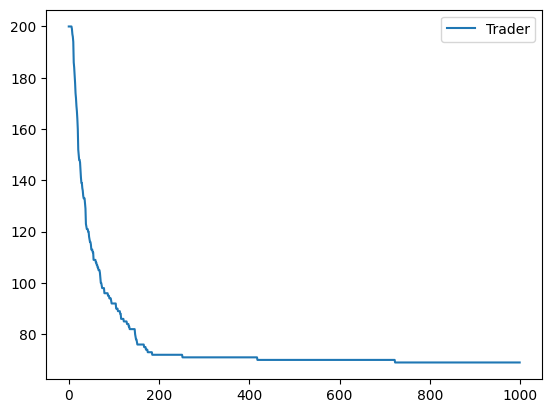

In [12]:
# plot number of agents per time step
results.plot(y = "Trader", use_index=True)

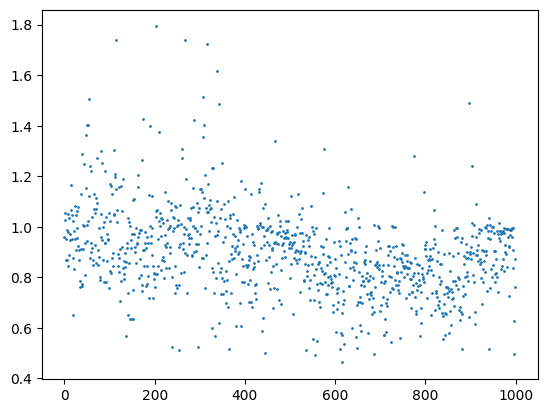

In [13]:
# plot trade price per step

y = list(results["Price"])
x = range(1000)

plt.scatter(x,y, s=1)

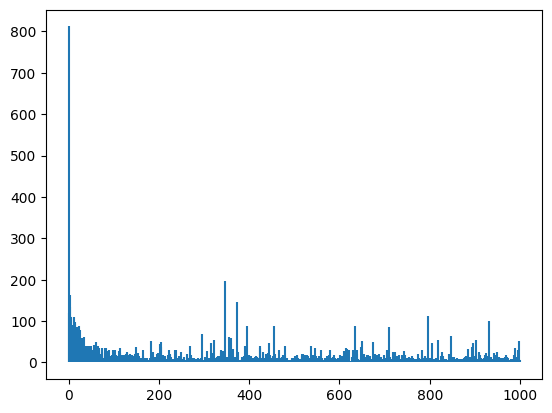

In [14]:
# Plot trade volume improved

for i in range(1000):
  plt.vlines(i,0,results["Trade Volume"][i])

In [15]:
#  create graph object
G = nx.Graph()

# add agent keys to make initial node set
G.add_nodes_from(list(model.schedule.agents_by_type[Trader].keys()))

# create edge list
for idx, row in agent_results.iterrows():
  if len(row["Trade Network"]) > 0:
    for agent in row["Trade Network"]:
      G.add_edge(idx[1], agent)



In [16]:
print("Connectivity: ", nx.node_connectivity(G), "Clustering: ",
      nx.average_clustering(G), "Efficiency: ", nx.global_efficiency(G))

try:
  print("Diameter: ", nx.diameter(G))
except:
  print("Some traders not connected")


Connectivity:  1 Clustering:  0.421831811085222 Efficiency:  0.4841120204427245
Diameter:  5


(array([45., 44., 33.,  7., 12., 11., 18., 13.,  9.,  5.]),
 array([ 1. ,  7.5, 14. , 20.5, 27. , 33.5, 40. , 46.5, 53. , 59.5, 66. ]),
 <BarContainer object of 10 artists>)

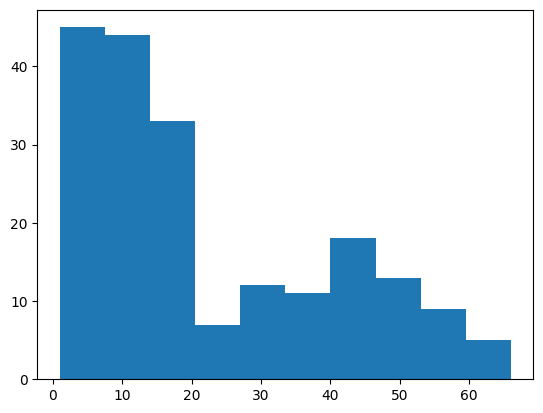

In [17]:
degree = [d for n,d in G.degree()]
plt.hist(degree)

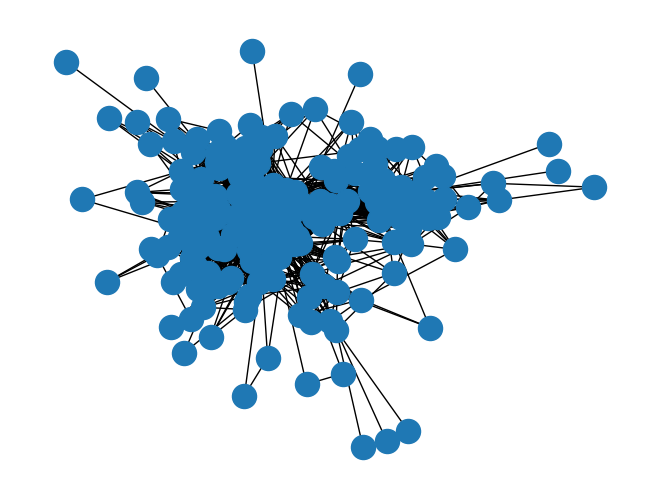

In [18]:
nx.draw(G)

# Batch Run and Analysis

In [19]:
params = { "width": 50, "height": 50,
          "vision_min": range(1,3),
          "metabolism_max": [3,5]}

results_batch = mesa.batch_run(
    SugarscapeG1mt,
    parameters = params,
    iterations = 1,
    number_processes = 1,
    data_collection_period = 1,
    display_progress = True
)

 25%|██▌       | 1/4 [01:00<03:01, 60.59s/it]/tmp/ipython-input-1755629435.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4/4 [03:16<00:00, 49.23s/it]


In [20]:
import pandas as pd

results_df = pd.DataFrame(results_batch)
results_df

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,535,1.029087,NaN,NaN
1,0,0,1,50,50,1,3,200,101,1.065013,4138.0,[]
2,0,0,1,50,50,1,3,200,101,1.065013,4139.0,"[4228, 4228, 4228, 4228, 4228, 4237, 4237]"
3,0,0,1,50,50,1,3,200,101,1.065013,4140.0,[]
4,0,0,1,50,50,1,3,200,101,1.065013,4141.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
434831,3,0,1000,50,50,2,5,70,6,0.997922,4322.0,[]
434832,3,0,1000,50,50,2,5,70,6,0.997922,4326.0,[]
434833,3,0,1000,50,50,2,5,70,6,0.997922,4329.0,[]
434834,3,0,1000,50,50,2,5,70,6,0.997922,4332.0,[]


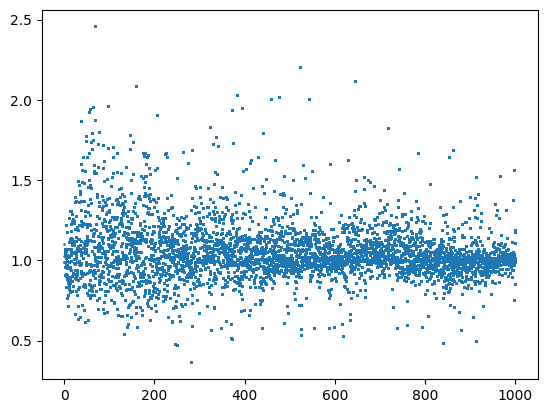

In [21]:
plt.scatter(results_df["Step"], results_df["Price"], s=0.75)

In [22]:
results_explore = results_df[results_df["metabolism_max"]== 3]
results_explore

,RunId,iteration,Step,width,height,vision_min,metabolism_max,Trader,Trade Volume,Price,AgentID,Trade Network
0,0,0,0,50,50,1,3,200,535,1.029087,NaN,NaN
1,0,0,1,50,50,1,3,200,101,1.065013,4138.0,[]
2,0,0,1,50,50,1,3,200,101,1.065013,4139.0,"[4228, 4228, 4228, 4228, 4228, 4237, 4237]"
3,0,0,1,50,50,1,3,200,101,1.065013,4140.0,[]
4,0,0,1,50,50,1,3,200,101,1.065013,4141.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
360192,2,0,1000,50,50,2,3,149,13,1.190006,4332.0,[4216]
360193,2,0,1000,50,50,2,3,149,13,1.190006,4333.0,[]
360194,2,0,1000,50,50,2,3,149,13,1.190006,4334.0,[]
360195,2,0,1000,50,50,2,3,149,13,1.190006,4335.0,[]


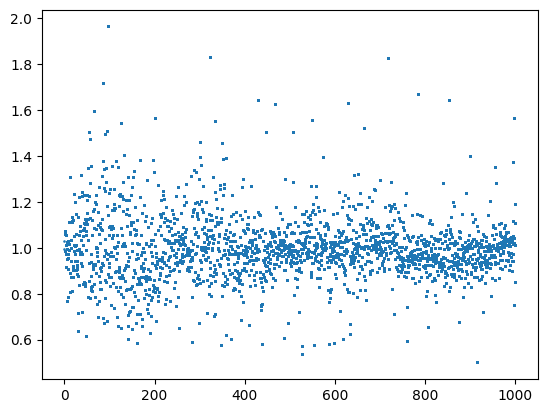

In [23]:
plt.scatter(results_explore["Step"], results_explore["Price"], s=0.75)

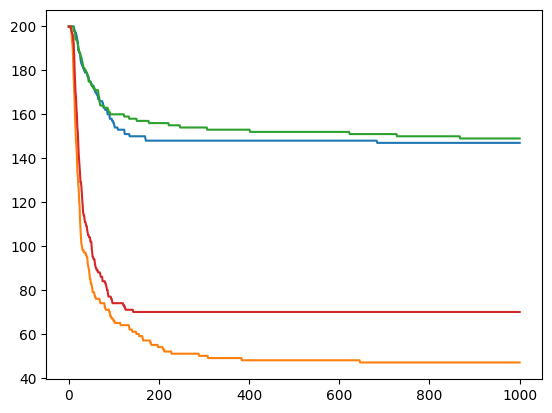

In [25]:
for i in range(4):
  results_explore = results_df[results_df["RunId"] ==i]
  plt.plot(results_explore["Step"], results_explore["Trader"])

In [26]:
#Agent results
G = nx.Graph()

trade = results_df.dropna(subset=["Trade Network"])
# add agent keys to make initial node set
G.add_nodes_from(list(trade["AgentID"].unique()))

# create edge list
for idx, row in trade.iterrows():
    if len(row["Trade Network"]) > 0:
        for agent in row["Trade Network"]:
            G.add_edge(row["AgentID"], agent)

In [27]:
#Get some statistics

print(f"Node Connectivity {nx.node_connectivity(G)}")
print(f"Average Clustering {nx.average_clustering(G)}")
print(f"Global Efficiency {nx.global_efficiency(G)}")

Node Connectivity 24
Average Clustering 0.6470139027388734
Global Efficiency 0.7826633165829145


(array([ 4.,  4.,  5., 11., 18., 38., 29., 39., 27., 25.]),
 array([ 24. ,  37.6,  51.2,  64.8,  78.4,  92. , 105.6, 119.2, 132.8,
        146.4, 160. ]),
 <BarContainer object of 10 artists>)

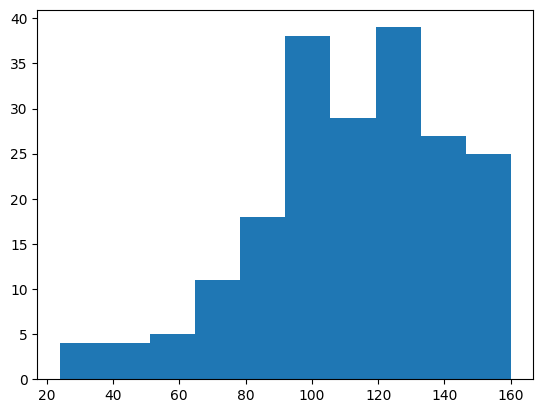

In [28]:
#Plot a histogram of number of links

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
degree_sequence = [d for n, d in G.degree()]
plt.hist(degree_sequence)

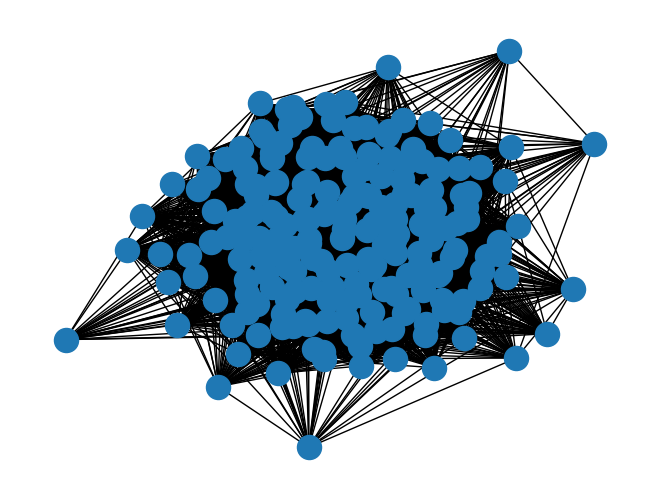

In [29]:
# Plot network
nx.draw(G)